# MEPSA Tests Notebook

#### DA FARE
- Implementare il taglio su minimo 0.128 secondi tra i picchi e vedere cosa succede alla distribuzione di deltaT e di Npeaks  

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)

---

**BATSE**:

    res      = 0.064 [s]

    eff_area = 3600 [cm2]

    bg_level = 10.67 [cnt/cm2/s]

---

**Swift**:
- [Area Efficace](https://swift.gsfc.nasa.gov/proposals/tech_appd/swiftta_v17/node27.html): approximately 1400 cm^2
- [Background Swift](https://swift.gsfc.nasa.gov/proposals/tech_appd/swiftta_v17/node32.html): The typical BAT background event rate in the full array above threshold is about 10 000 counts per second

    res      = 0.064 [s]

    eff_area = 1400 [cm2]  

    bg_level = 10000 [cnt/s] /eff_area = 10000/1400 [cnt/cm2/s] 


---

**BeppoSAX**:
- [Il catalogo e lo strumento](https://ui.adsabs.harvard.edu/abs/2009ApJS..180..192F/abstract)

- Area geometrica: circa 1136 cm^2 per pannello. L'area efficace dipende fortemente da energia e direzione di arrivo dei fotoni
- [Area efficace](https://iopscience.iop.org/article/10.1086/308737/fulltext/50075.text.html) : 420 cm^2 secondo questa reference (nel migliore dei casi)
- [BACKGROUND: Misura delle performance in volo dello strumento](https://ui.adsabs.harvard.edu/abs/1997SPIE.3114..186F/abstract) : qui è presente una misura del bkg medio: 1000 cnt/s (pag. 4, paragrafo 3)

    res      = 1 [s]

    res (HR) = 0.0078125 [s]

    eff_area = 420 [cm2]

    bg_level = 1000 [cnt/s] /eff_area = 1000/420 [cnt/cm2/s]
---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

from statistical_test import *

#SEED=42
#np.random.seed(SEED)

In [2]:
# set the username for the path of the files:
#user='LB'
user='AF'
#user='bach'
if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = ''
    swift_sim_path     = ''
    beppo_sax_sim_path = ''
    # mepsa
    mepsa_path      = ''
    ex_pattern_path = ''
elif user=='LB':
    # real data
    batse_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse/'
    swift_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swft/'
    beppo_sax_sim_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax/'
    # mepsa
    mepsa_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
elif user=='AF':
    batse_path = 'E:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path = 'E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path = 'E:/grb_to_test/Swift_BAT/'
    sax_path   = 'E:/grb_to_test/BeppoSAX_GRBM/'
    batse_sim_path   = 'E:/grb_to_test/simulations/batse/'
    swift_sim_path   = 'E:/grb_to_test/simulations/swift/'
    beppo_sax_sim_path_hr = 'E:/grb_to_test/simulations/sax_hr/'
    beppo_sax_sim_path_lr = 'E:/grb_to_test/simulations/sax_lr/'
    mepsa_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [3]:
t_i     = 0   # [s]
t_f     = 150 # [s]
t_f_sax = 50  # [s]

# BATSE
bin_time_batse     = instr_batse['res'] # [s] temporal bins for BATSE
test_times_batse   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))
sn_threshold_batse = instr_batse['sn_threshold']
t90_threshold      = instr_batse['t90_threshold'] 

# Swift
bin_time_swift     = instr_swift['res'] # [s] temporal bins for Swift
test_times_swift   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))
sn_threshold_swift = instr_swift['sn_threshold']
t90_threshold      = instr_swift['t90_threshold'] 

# BeppoSAX (HR)
bin_time_sax_hr   = instr_sax['res']    # [s] temporal bins for BeppoSAX (HIGH resolution)
test_times_sax_hr = np.linspace(t_i, t_f_sax, int((t_f_sax-t_i)/bin_time_sax_hr))
sn_threshold_sax  = instr_sax['sn_threshold'] 
t90_threshold     = instr_sax['t90_threshold'] 

# BeppoSAX (LR)
bin_time_sax_lr     = instr_sax_lr['res']  # [s] temporal bins for BeppoSAX (LOW resolution)
test_times_sax_lr   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax_lr))
sn_threshold_sax_lr = instr_sax_lr['sn_threshold'] 
t90_threshold       = instr_sax_lr['t90_threshold'] 


## Test 5: Number of significative peaks

#### Run MEPSA on the simulated curves for BATSE

In [31]:
#reb_factor = 32
#peak_sn_level = 5
#n_of_peaks_sim = [runMEPSA(mepsa_path, ex_pattern_path, grb.data_file_path, reb_factor, grb.name, peak_sn_level) for grb in tqdm(grb_list_sim_batse)]

#### Alternatively, read the result of MEPSA from the folder in which they are stored

In [6]:
mepsa_out_file_list = ['E:/grb_to_test/MEPSA results/BATSE_sim_paper_par/' + file for file in os.listdir('E:/grb_to_test/MEPSA results/BATSE_sim_paper_par')]
n_of_peaks_sim = readMEPSAres(mepsa_out_file_list, 32, 5)

#### Read the MEPSA outputs for the real BATSE data already evaluated by Cristiano

In [7]:
mepsa_out_file_list = [batse_mepsa_res_path+file for file in os.listdir(batse_mepsa_res_path) if file.startswith('peaks_')]
n_of_peaks_batse = readMEPSAres(mepsa_out_file_list, 32, 5)

#### Makes plot

Text(0.5, 0, 'Number of significative peaks')

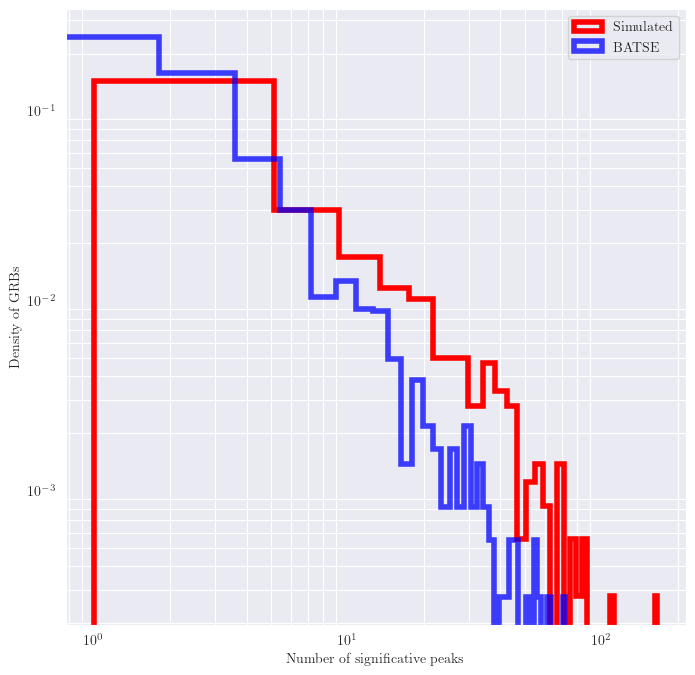

In [8]:
n_bins = 40
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.hist(n_of_peaks_sim, 
         bins=n_bins, 
         label ='Simulated', 
         alpha=1.00,
         color='r',
         histtype='step',
         linewidth=4,
         density=True)

ax.hist(n_of_peaks_batse, 
         bins=n_bins,
         alpha=0.75,
         label='BATSE', 
         color='b',
         histtype='step',
         linewidth=4,
         density=True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Density of GRBs')
ax.set_xlabel('Number of significative peaks')

## Peak count method test

In [4]:
grb_list_test = load_lc_sim(path="C:/Users/Lisa/Desktop/Mepsa_test3/dataset/")
# apply constraints
grb_list_test = apply_constraints(grb_list=grb_list_test, 
                                       bin_time=bin_time_batse, 
                                       t90_threshold=t90_threshold, 
                                       sn_threshold=sn_threshold_batse, 
                                       t_f=t_f)


100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


Total number of simulated GRBs:  500
Total number of input GRBs:  500
GRBs with negative duration:  0
GRBs that satisfy the constraints:  500


In [5]:
# reb_factor = 32
# peak_sn_level = 5

# n_of_peaks_sim = [runMEPSA(mepsa_path, ex_pattern_path, grb.data_file_path, reb_factor, grb.name, peak_sn_level) for grb in tqdm(grb_list_test)]

100%|██████████| 500/500 [21:11<00:00,  2.54s/it]


In [6]:
if user=='AF':
    sim_time_deltas = np.loadtxt('C:/Users/Lisa/Desktop/Mepsa_test3/time_distances.txt') # AF
elif user=='LB':
    sim_time_deltas = np.loadtxt('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/time_distances.txt') # LB

In [7]:
if user=='AF':
    sim_time_mepsa = []
    path = 'C:/Users/Lisa/Desktop/Mepsa_test3/MEPSA_res'
    for file in os.listdir(path):
        mepsa_res = open(path + '/' + file, 'r')
        mepsa_res.readline()
        peak_times = []
        for line in mepsa_res:
            peak_times.append(float(line.split()[3]))
        peak_times = np.array(peak_times)
        sim_time_mepsa.extend(np.diff(peak_times))
elif user=='LB':
    sim_time_mepsa = []
    path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res'
    for file in os.listdir(path):
        mepsa_res = open(path + '/' + file, 'r')
        mepsa_res.readline()
        peak_times = []
        for line in mepsa_res:
            peak_times.append(float(line.split()[3]))
        peak_times = np.array(peak_times)
        sim_time_mepsa.extend(np.diff(peak_times))

In [12]:
min(sim_time_mepsa)

0.1279999999999999

## Results with only FWHM selection

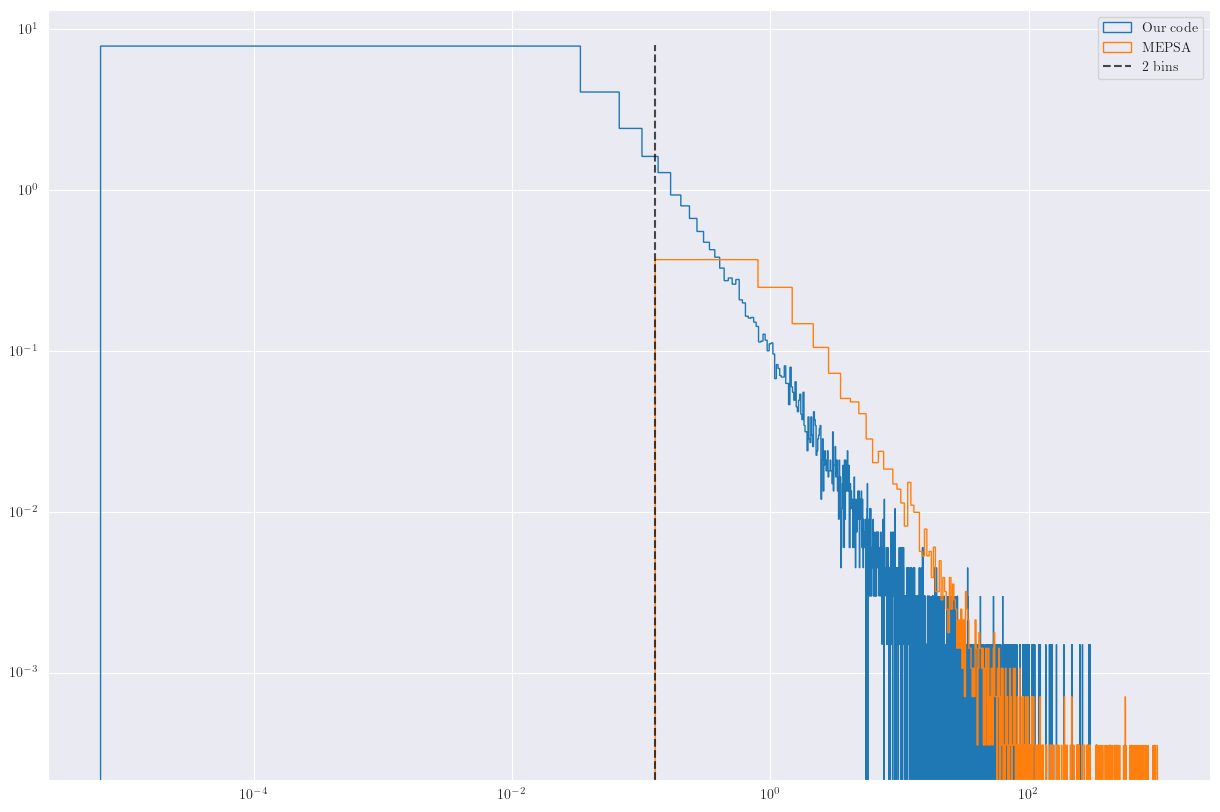

In [13]:
#print(min(sim_time_deltas))
plt.figure(figsize=(15,10))
plt.hist(sim_time_deltas, bins='auto', histtype='step', density=True, label='Our code')
plt.hist(sim_time_mepsa,  bins='auto', histtype='step', density=True, label='MEPSA')
plt.plot([0.128,0.128],[0,8], c='k', ls='--', alpha=0.7, label='2 bins')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## Results with both FWHM selection and minimum delay time selection

Text(0.5, 0, 'Time delay between puses')

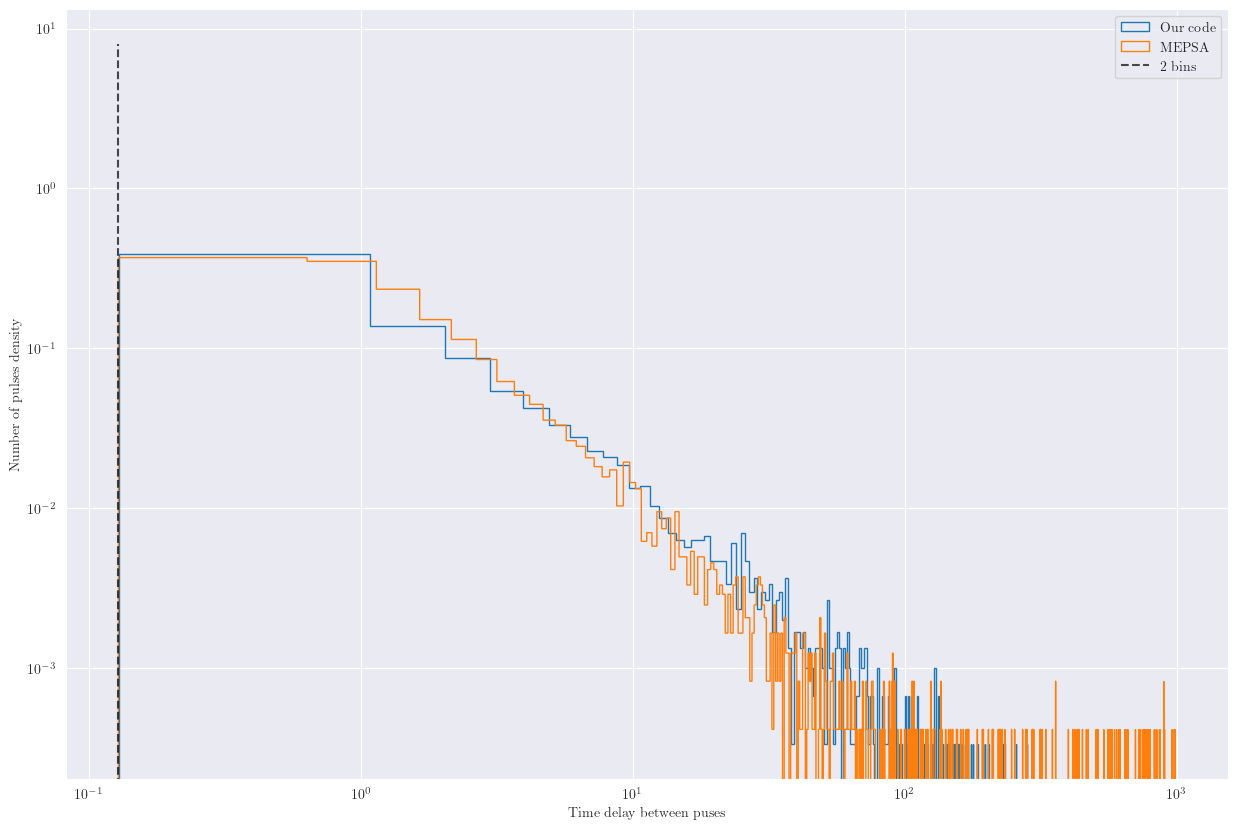

In [11]:
#print(min(sim_time_deltas))
plt.figure(figsize=(15,10))
plt.hist(sim_time_deltas, bins='auto', histtype='step', density=True, label='Our code')
plt.hist(sim_time_mepsa,  bins='auto', histtype='step', density=True, label='MEPSA')
plt.plot([0.128,0.128],[0,8], c='k', ls='--', alpha=0.7, label='2 bins')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Number of pulses density')
plt.xlabel('Time delay between puses')

In [8]:
grb_name = range(500)

gen_file = open("C:/Users/Lisa/Desktop/MEPSA_test3/n_of_pulses.txt", 'r')
good_pulses = []
#generated_pulses = []
for line in gen_file:
    good_pulses.append(float(line.split()[0]))
    #generated_pulses.append(float(line.split()[2]))

mepsa_pulses = []
for grb in grb_name:
    mepsa_pulses.append(len(open('C:/Users/Lisa/Desktop/MEPSA_test3/MEPSA_res/{0}.dat'.format(grb),'r').readlines()) -1 )

Text(0, 0.5, 'GRBs density')

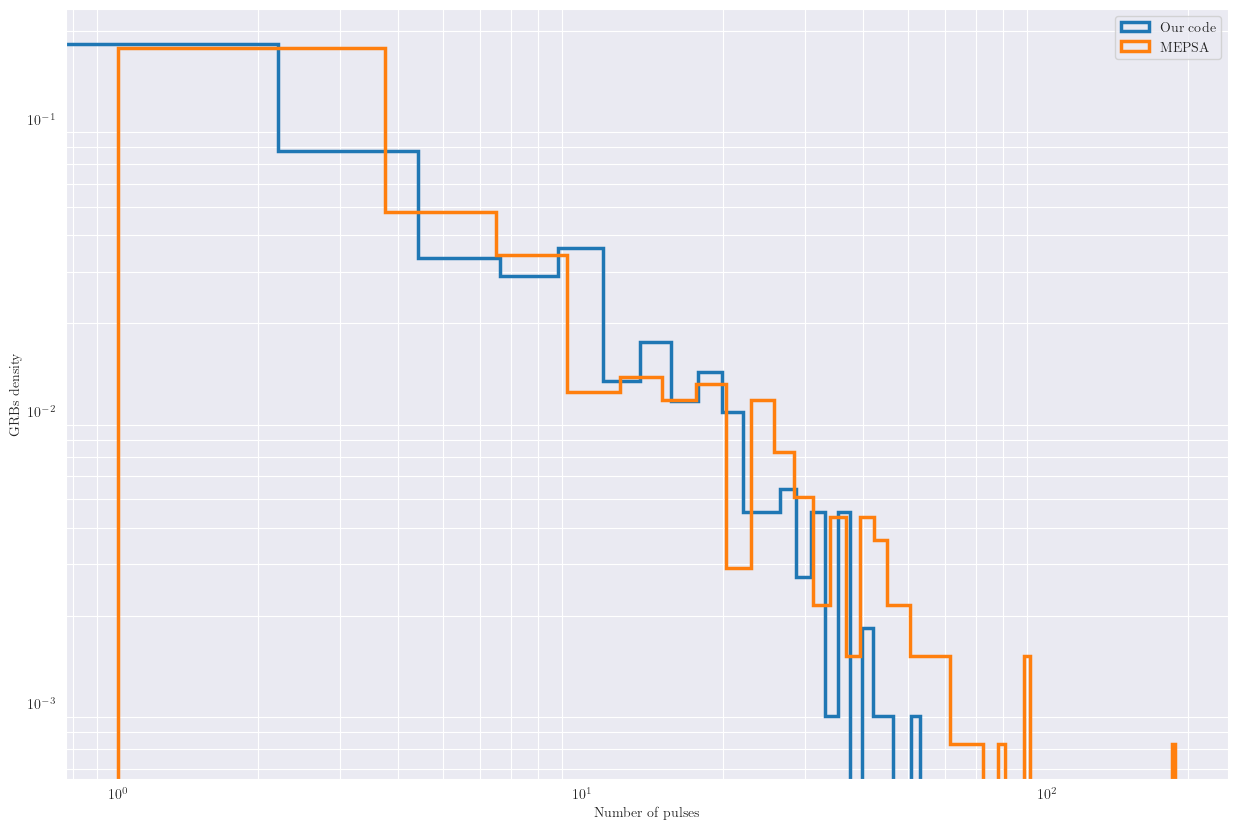

In [9]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
ax.hist(good_pulses, bins = 'auto', label = 'Our code', histtype = 'step', linewidth = 2.5, density = True)
ax.hist(mepsa_pulses, bins = 'auto', label = 'MEPSA', histtype = 'step', linewidth = 2.5, density = True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.grid(which='both')
ax.set_xlabel('Number  of pulses')
ax.set_ylabel('GRBs density')